In [1]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import stanza

from plotly.subplots import make_subplots
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer

tqdm.pandas()

import plotly.io as pio
pio.renderers.default = 'png'

In [2]:
# We allow the program to read in saved tables in order to reduce running time, which can be quite large.
recalculate_all = False

In [3]:
base_path = '.'
spreadsheets_path = 'Movie_spreadsheets'
data_path = os.path.join(base_path, spreadsheets_path)
intermediate_path = os.path.join(base_path, 'intermediate')

# Data Processing

In [4]:
def split_lines_with_character_tags(df):
    # Remove text which are labeled character names but which are not all caps (which often indicate stage directions)
    df = df.sample(frac=1).reset_index(drop=True)
    df['line #'] = df.index
    df['line'] = df['line'].str.replace('\n', ' ', regex=True)
    df = df[df['character'].str.isupper()]
    
    # Remove parentheticals such as "(CONTD)" or "(V.O.)"
    df['character'] = df['character'].str.replace(r"\(.+\)", '', regex=True).str.strip()
    df['original character'] = df['character']
    df['line'] = df['line'].str.replace(r'\(cont.+d\)', '', flags=re.IGNORECASE, regex=True)
    df = df[df['character'].str.strip().str.len() != 0]


    for character in df['original character'].unique():
        # If the name of a character (ONLY if in all caps, as is expected of character headers)
        # appears in a section of speech, separate it into another section of speech.
        # This is because we frequently observed one character's speech being contaminated with another's, e.g.:
            # SAM: Hi there how's it going? ALICE: I'm doing well
            # SAM: Glad to hear it.
        while len(df[df['line'].str.contains(re.escape(character), regex=True)]) > 0:
            new_rows = df[df['line'].str.contains(character, regex=True)].copy()
            new_rows.loc[:,'line'] = new_rows['line'].str.split(character).apply(lambda x: x[1])
            df.loc[:,'line'] = df['line'].str.split(character).apply(lambda x: x[0])
            new_rows['character'] = character
            new_rows.loc[:,'line #'] += .001
            df = df.append(new_rows)
            df = df.sort_values(by='line #').reset_index(drop=True)
            df.loc[:, 'line #'] = df.index

    df = df.drop('original character', axis=1)        
    df['character'] = df['character'].str.replace(r'[^A-z]','', regex=True)

    df ['line'] = df['line'].str.replace('\r', '', regex=True)
    df['line'] = df['line'].str.replace('\\\'', '\'', regex=True)
    df = df[df['line'].str.strip().str.len() != 0]
    df = df[df['character'].str.strip().str.len() != 0]
    df = df.dropna()
    return df

In [5]:
# Silence chained assignment warnings which are incorrect
pd.options.mode.chained_assignment = None

In [6]:
if recalculate_all:
    # For every movie in the dataset, run the cleaning function
    df = pd.DataFrame()
    movie_id = 0
    for file in tqdm(sorted(os.listdir(data_path))):
        if file.endswith('.csv'):
            movie_title = file.replace('.csv', '')
            # print(movie_title)
            individual_df = pd.read_csv(os.path.join(data_path, file), index_col=0)
            # print(file)
            # print(individual_df.head())
            individual_df['movie_id'] = movie_id
            movie_id += 1
            individual_df['movie_title'] = movie_title
            individual_df = split_lines_with_character_tags(individual_df)
            df = df.append(individual_df)

    # Weird problem in the labeling of Black Panther
    df = df[~df['character'].isin(['T', 'A', 'N'])]
    df = df.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████| 90/90 [00:03<00:00, 23.01it/s]


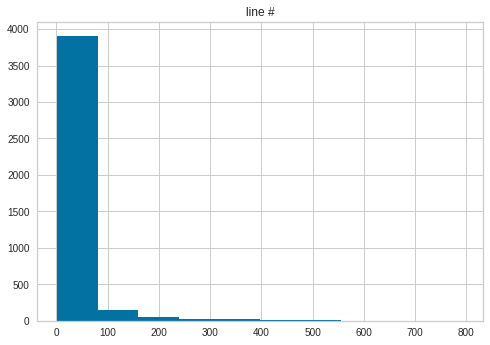

In [7]:
if recalculate_all:
    # Find the number of lines per character
    character_counts = pd.DataFrame(df.groupby(['character', 'movie_title'])['line #'].count())
    character_counts.hist()

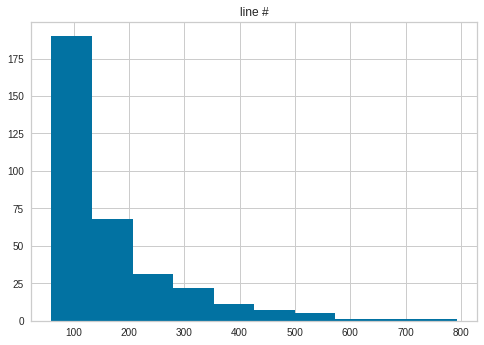

In [8]:
if recalculate_all:
    top_character_counts = character_counts[character_counts['line #'] >= 60]
    bottom_character_counts = character_counts[character_counts['line #'] <= 60]
    top_character_counts.hist()

In [9]:
if recalculate_all:
    # Drop any characters who have less than 60 lines
    for character, movie in tqdm(bottom_character_counts.index):
        df = df[~((df['character'] == character) & (df['movie_title'] == movie))]

100%|███████████████████████████████████████████████████████████| 3833/3833 [00:24<00:00, 156.01it/s]


# Sentiment Scoring

We use the stanford Stanza library to assign a sentiment score to every line. The library assigns sentiment scores for each sentence (0, 1, or 2). If a line contains multiple sentences, we take the average (mean) sentiment of the line.

In [10]:
if recalculate_all:
    stanza.download('en')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', use_gpu=False)

    def sentiment_score(text):
        doc = nlp(text)
        scores = []
        for i, sentence in enumerate(doc.sentences):
            scores.append(sentence.sentiment)
        return np.mean(scores)
    
    df['sentiment'] = df['line'].progress_apply(sentiment_score)

2021-11-30 01:42:30 INFO: Downloading default packages for language: en (English)...
2021-11-30 01:42:31 INFO: File exists: /home/aaron/stanza_resources/en/default.zip.
2021-11-30 01:42:33 INFO: Finished downloading models and saved to /home/aaron/stanza_resources.
2021-11-30 01:42:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-11-30 01:42:33 INFO: Use device: cpu
2021-11-30 01:42:33 INFO: Loading: tokenize
2021-11-30 01:42:33 INFO: Loading: sentiment
2021-11-30 01:42:34 INFO: Done loading processors!
100%|██████████████████████████████████████████████████████████| 54182/54182 [09:40<00:00, 93.26it/s]


In [11]:
# Get a new line ID which gives the position of the line in the whole movie, not simply in the character's lines
# This enables us to know, for example, whether a line occurred in the beginning or end of the movie
# rather than just in the beginning or end of a character's own dialog
if recalculate_all:
    df['movie_length'] = 0
    for movie_id in tqdm(df['movie_id']):
        movie_length = df.loc[df['movie_id'] == movie_id]['line #'].max()
        df.loc[df['movie_id'] == movie_id, 'movie_length'] = movie_length
    df['relative_line_id'] = df['line #'] / df['movie_length']

100%|████████████████████████████████████████████████████████| 54182/54182 [00:28<00:00, 1890.48it/s]


In [12]:
# Assign an index which contains both the character and movie name. 
# If we did not elect to recalculate everything, we now load in the existing sentiment scores
if recalculate_all:
    df['combined_name'] = df['movie_title'].str.cat(df['character'], sep='_')
    df.to_csv(os.path.join(intermediate_path, 'movie_df_shuffled.csv'))
else:
    df = pd.read_csv(os.path.join(intermediate_path, 'movie_df_shuffled.csv'))

In [13]:
if recalculate_all:
    expanded_movie_size = df['movie_length'].max()
    sentiment_df = np.ones(shape=(len(df['combined_name'].unique()), expanded_movie_size))
    sentiment_df = pd.DataFrame(sentiment_df)
    sentiment_df.index = df['combined_name'].unique()

    # Arbitrarily mark cells whose sentiment scores did not originate from the movie dataframe.
    # True sentiment scores cannot be less than 0
    sentiment_df = sentiment_df * -10
    
    # We standardize the length of movies by assigning each line to the index of its relative position in the movie 
    # (e.g. 66% of the way through) to its position in the expanded standardized movie length
    # e.g. if the longest movie had 5000 lines, a line at 66% of the way through its own movie
    # would be assigned to position 3300 in its new "relative" movie length
    for row in df.iterrows():
        sentiment_df.loc[row[1]['combined_name'], np.round(row[1]['relative_line_id'] * (expanded_movie_size - 1))] = row[1]['sentiment']

In [14]:
np.random.seed(42)

def expand_row(row):
    # To allow comparison, we needed to fill in the empty values where character was not speaking. We elected to 
    # maintain the character's previous sentiment for all non-speaking lines, adding some gaussian noise
    row = row.copy()
    std = row[row != -10].std()
    if row[0] == -10:
        first_nonempty_index = row[row != -10].index[0]
        first_nonempty_value = row[row != -10].loc[first_nonempty_index]
        gaussian_noise = np.random.normal(0, std, size=first_nonempty_index)
        row[:first_nonempty_index] = first_nonempty_value + gaussian_noise
    for i in range(len(row)):
        if row[i] == -10:
            gaussian_noise = np.random.normal(0, std)
            row[i] = last_val + gaussian_noise
        else:
            last_val = row[i]
    # Standardize each character's arc to have a mean of 0 and a standard deviation of 1
    # std = row.std()
    # row = (row - row.mean()) / std

    return row
        
if recalculate_all:
    sentiment_df = sentiment_df.progress_apply(expand_row, axis=1)
    sentiment_df.to_csv(os.path.join(intermediate_path, 'sentiment_df_shuffled.csv'))
else:
    sentiment_df = pd.read_csv(os.path.join(intermediate_path, 'sentiment_df_shuffled.csv'), index_col=0)

100%|██████████████████████████████████████████████████████████████| 328/328 [00:05<00:00, 63.25it/s]


# PCA

We perform principal component analysis for dimensionality reduction to inspect for visible clusters

In [15]:
pca = PCA(random_state=42)

In [16]:
normalized_sentiment_df = sentiment_df.copy().T
normalized_sentiment_df = (normalized_sentiment_df - normalized_sentiment_df.mean()) / normalized_sentiment_df.std()
normalized_sentiment_df = normalized_sentiment_df.T


In [17]:
# For PCA, we use a very small smoothing window (3 timepoints across) to reduce noise
rolling_df = normalized_sentiment_df.rolling(3, axis=1).mean().dropna(axis=1)

In [18]:
pca_df = pd.DataFrame(pca.fit_transform(rolling_df))
pca_df.index = rolling_df.index

Plot the standard deviation of all movies across time

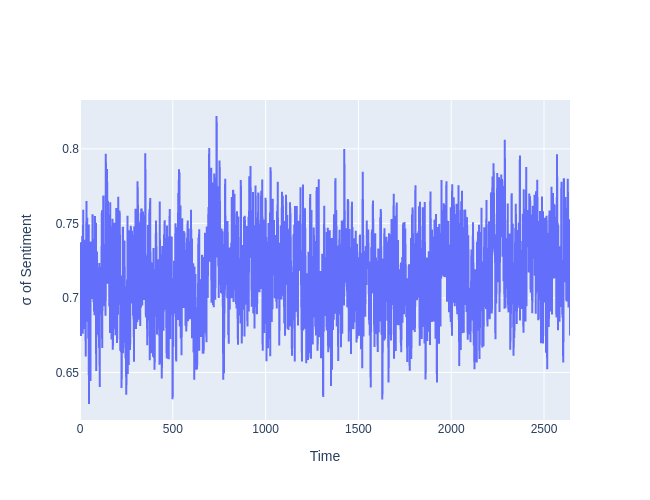

In [19]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.std(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="σ of Sentiment",
                  )
fig.show()

array([[<AxesSubplot:title={'center':'relative_line_id'}>]], dtype=object)

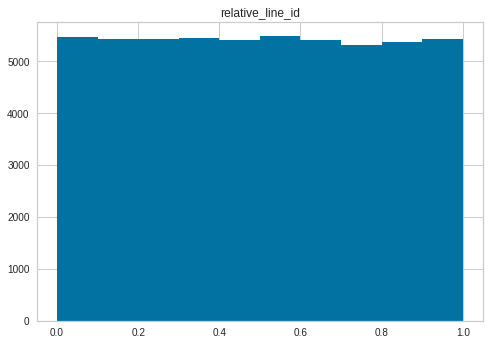

In [20]:
df.hist('relative_line_id')

#### Plot the average sentiment over time for all characters

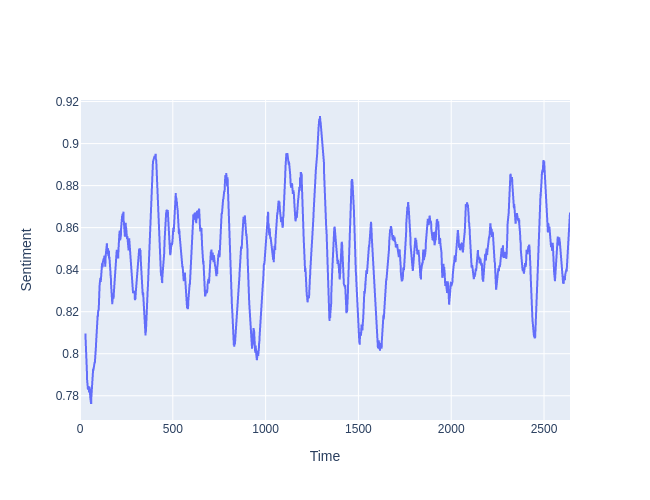

In [21]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.mean().rolling(30).mean(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

All characters' first two principal components visualized

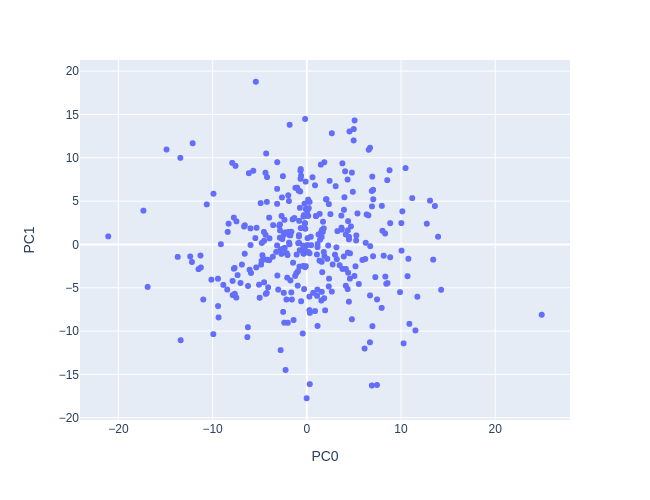

In [22]:
fig = px.scatter(pca_df.reset_index(), 0, 1, hover_name='index', width=650, height=500)
fig.update_layout(
    xaxis_title="PC0",
    yaxis_title="PC1",

)
fig.show()

#### First Principal Component

In [23]:
midpoint = len(sentiment_df) // 2

def melt_sentiment_df(df):
    return pd.melt(df.reset_index(), id_vars='index').rename({'index': 'Character', 'variable': 'Time', 'value': 'Sentiment'}, axis=1)

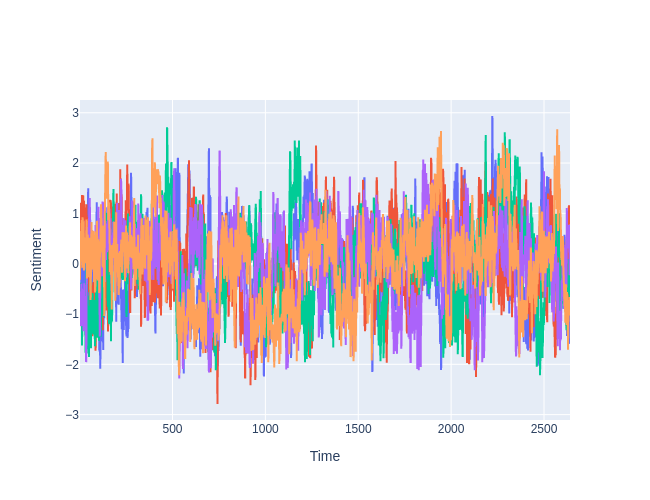

In [24]:

temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

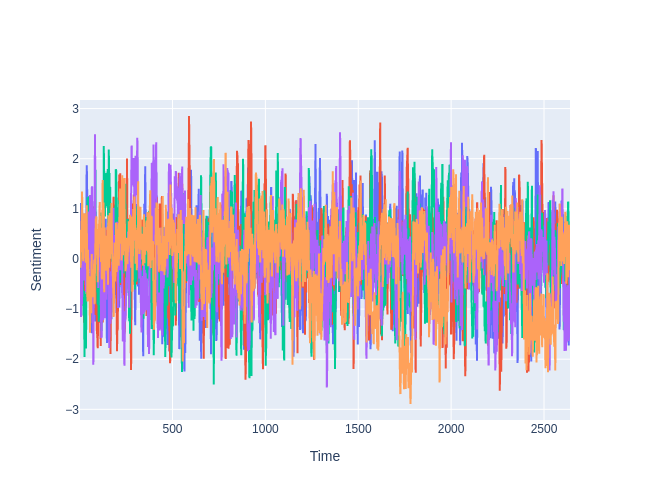

In [25]:
temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

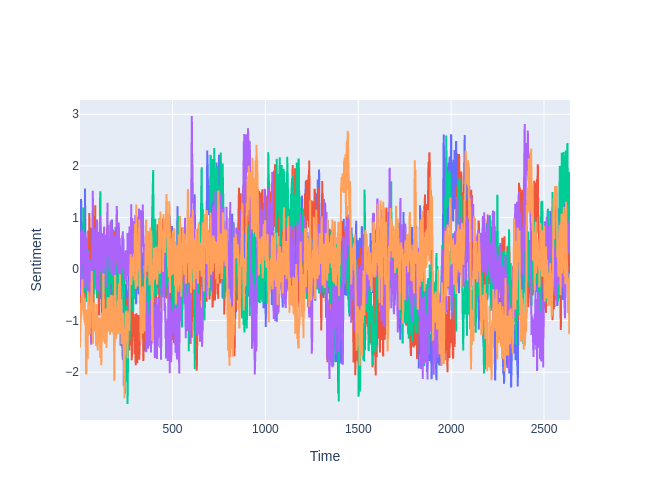

In [26]:
temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

#### Second Principal Component

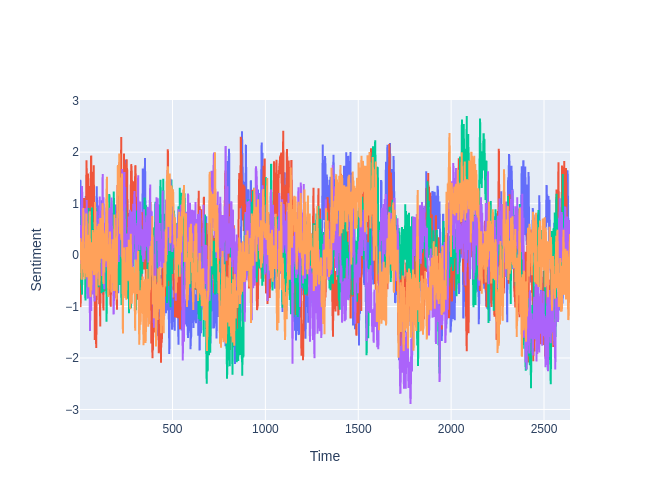

In [27]:
temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

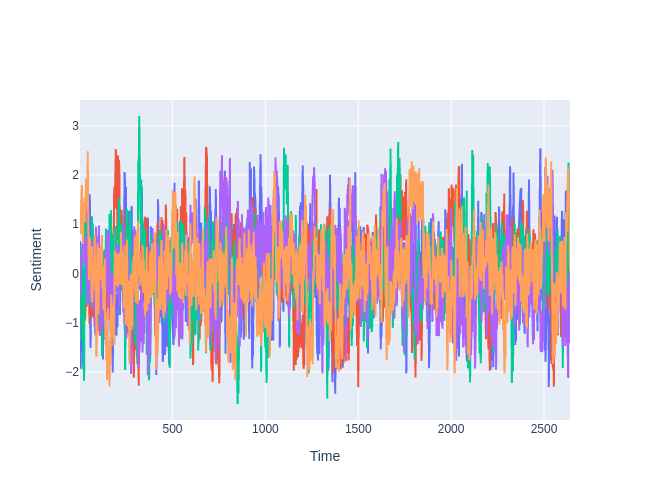

In [28]:
import plotly.graph_objects as go

temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  )
fig.show()

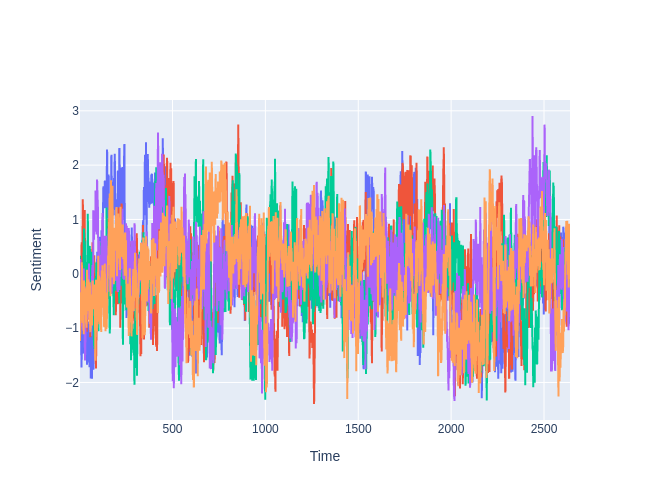

In [29]:
temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

In [30]:
# from sklearn.manifold import TSNE

# tsne = TSNE( learning_rate='auto', init='pca')
# tsne_df = pd.DataFrame(tsne.fit_transform(sentiment_df.rolling(200, min_periods=1, axis=1).mean().dropna(axis=1)))
# tsne_df['ix'] = sentiment_df.index

# px.scatter(tsne_df, x=0, y=1, hover_name='ix').show()

# Clustering

To reduce noise, we will use a sliding, smoothing window of length 500.

As one distance metric, we use dynamic time warping, which should be invariant to small translations in the exact timing of patterns

In [31]:
if recalculate_all:
    from tslearn.metrics import cdist_dtw as dtw
    distances = dtw(sentiment_df, n_jobs=-1)

    dtw_df = pd.DataFrame(distances)
    dtw_df.index = sentiment_df.index
    dtw_df.columns = sentiment_df.index

    dtw_df.to_csv(os.path.join(intermediate_path, 'distances_shuffled.csv'))
else:
    dtw_df = pd.read_csv(os.path.join(intermediate_path, 'distances_shuffled.csv'), index_col=0)

/home/aaron/miniconda3/envs/test-CSC/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning:

h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/



# Clustering

## Setup

In [32]:
rolling_window = 500

In [33]:
rolling_sentiment_df = sentiment_df.rolling(rolling_window, axis=1, center=True).mean().dropna(axis=1)

In [34]:
def find_subplot_dimensions(n):
    return (int(np.ceil(n / 3)), 3)

In [35]:
sentiment_df

,0,1,2,3,4,5,6,7,8,9,...,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640
8mm_MAX,1.230595,0.935812,1.300683,1.707051,0.891297,0.891304,1.000000,1.733134,1.356274,1.000000,...,1.810543,1.537703,2.302283,2.398527,1.891080,2.017752,1.327506,1.860878,1.976693,3.216677
8mm_EDDIE,0.120461,1.385881,1.156331,0.804517,1.530513,0.849447,0.857824,0.640573,1.267692,1.205260,...,0.235537,0.358061,-0.340087,-0.323725,-0.282002,0.263490,0.507850,-0.200147,0.445997,0.060654
8mm_WELLES,1.939526,1.897147,2.363278,2.158416,3.107346,1.585334,2.252092,1.742507,1.577032,1.994712,...,0.705176,1.174107,0.104964,-0.292328,0.087378,0.434955,0.361658,0.141899,-0.595623,0.500000
ALongKissGoodnight_SAMANTHA,0.500000,0.715862,1.404929,0.713003,0.779477,0.762643,0.682169,0.927457,0.681401,1.000000,...,1.243537,0.507611,1.053037,0.986343,1.147546,1.053455,1.174210,0.857096,1.026890,0.436661
ALongKissGoodnight_CHARLY,-0.144266,0.627212,0.143770,-0.009435,0.855078,-0.613683,-0.500321,0.772366,0.020727,-0.109395,...,1.323746,0.688252,1.027048,0.389376,0.780845,0.871302,-0.392720,0.313555,0.928278,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wildwildwest_WEST,0.053450,1.179854,1.163886,0.807253,0.575457,0.125790,1.824101,0.565371,1.550687,1.098966,...,0.271324,0.211840,1.201151,1.462146,0.006760,0.074330,0.349447,0.958465,0.049377,0.214482
wildwildwest_LOVELESS,1.247441,1.595858,2.280032,0.675479,2.482909,1.158307,-0.264029,2.058928,0.936545,0.341132,...,0.199241,-1.242205,-0.014992,-0.045440,0.598167,-0.068270,-1.126790,1.012023,-0.897867,-0.276661
willow_WILLOW,1.000000,0.927217,-0.078082,1.298982,0.894384,1.890098,0.072558,1.000000,1.149682,2.200049,...,0.116515,0.603961,2.000000,2.839535,1.873535,2.302439,2.283488,2.280089,1.543147,2.632425
willow_SORSHA,1.920803,0.532427,0.062564,0.500000,0.644927,1.215665,-0.377435,0.272896,0.861065,1.225908,...,1.308226,1.518420,1.175019,1.310247,1.610561,1.290291,2.074136,0.671105,0.838253,1.176475


In [36]:
# We settled on 9 clusters as a minimum of the optimal clusterings from all of our models
n_clusters=9

def cluster(data, model):
    """
    This function helps to calculate and visualize clusters using whatever
    clustering model is passed in
    """
    visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
    visualizer.fit(data)        # Fit data to visualizer
    visualizer.show()
    # n_clusters = visualizer.elbow_value_
        
    model.set_params(n_clusters=n_clusters)
    cluster_df = pd.Series(model.fit_predict(data), index=sentiment_df.index)
    cluster_df = cluster_df.rename({0: 'cluster'})
    clusters = cluster_df.unique()
    clusters.sort()
    rows, cols = find_subplot_dimensions(n_clusters)
    outer_fig = make_subplots(
        rows=rows, 
        cols=cols, 
        shared_xaxes='all', 
        shared_yaxes='all',
        x_title='Time',
        y_title='Sentiment',
        horizontal_spacing=0.03,
        vertical_spacing=0.05,
        subplot_titles=(["Cluster {}".format(i) for i in range(n_clusters)])
    )
    outer_fig.update_layout(showlegend=False, 
                    width=(cols+1)*200, 
                    height=(rows+1)*200,
                )

    
    plotted_count = 0
    
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            if plotted_count < n_clusters:
                indices = cluster_df[cluster_df == plotted_count].dropna().index
                temp_df = rolling_sentiment_df.loc[indices]
                
                # Normalize the data for clean visualizations
                temp_df = temp_df.copy().T
                temp_df = (temp_df - temp_df.mean()) / temp_df.std()
                temp_df = temp_df.T

                for index in temp_df.index:
                    outer_fig.append_trace(
                        go.Scatter(
                            x=temp_df.columns, y=temp_df.loc[index],
                            mode='lines',
                            # text=index, 
                            marker=dict(
                                color='rgba(135, 206, 250, 0.8)',
                            ),
                            hoverinfo='none',
                            ), 
                        i, 
                        j)
                outer_fig.append_trace(
                    go.Scatter(
                        x=temp_df.columns, y=temp_df.mean(),
                        mode='lines',
                        marker=dict(
                            color='rgba(128, 128, 128, .8)',
                        ),
                    ), 
                    i, 
                    j
                )
                plotted_count += 1
    outer_fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(
        title=dict(
            text='Sentiment'
        )
    )
    outer_fig.show()
    return cluster_df

In [37]:
if not os.path.exists(os.path.join(base_path, 'clusters_shuffled.csv')):
    clusters_df = pd.DataFrame(index=sentiment_df.index)
else:
    clusters_df = pd.read_csv(os.path.join(base_path, 'clusters_shuffled.csv'), index_col=0)

### Euclidean

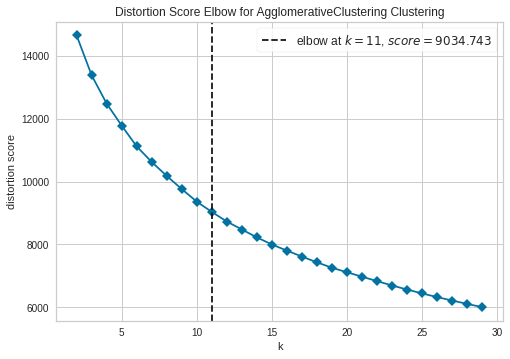

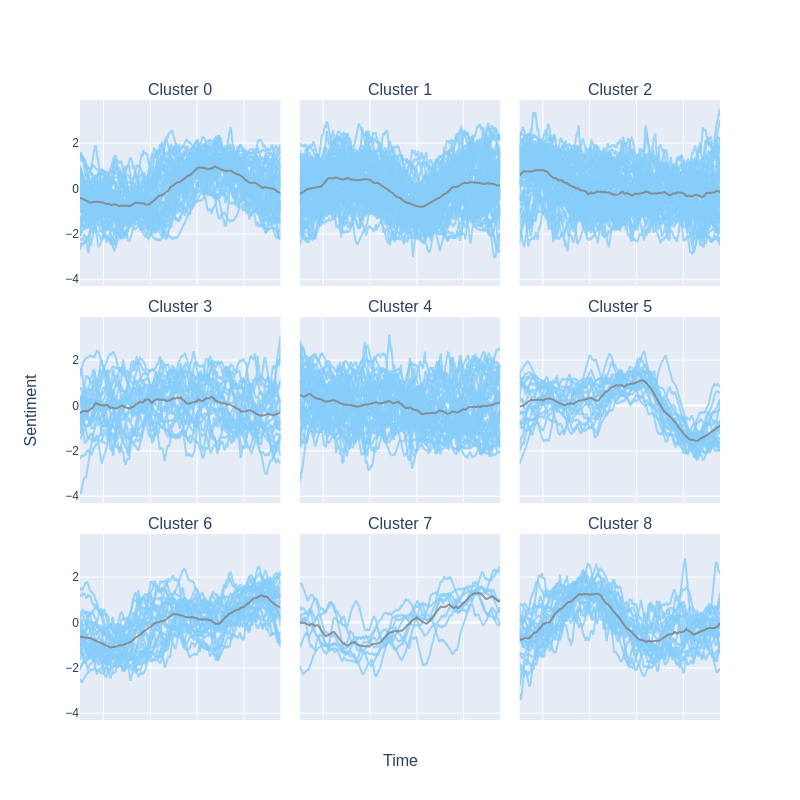

In [38]:
model = AgglomerativeClustering()
clusters_df['euclidean_sentiment'] = cluster(rolling_sentiment_df, model)

### Manhattan

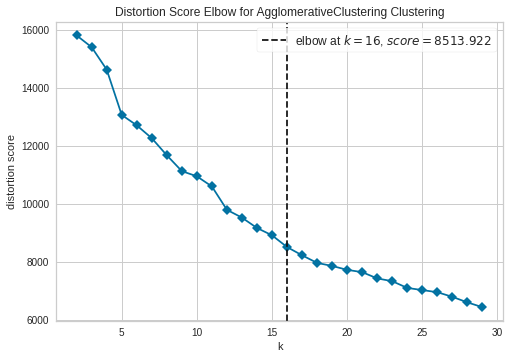

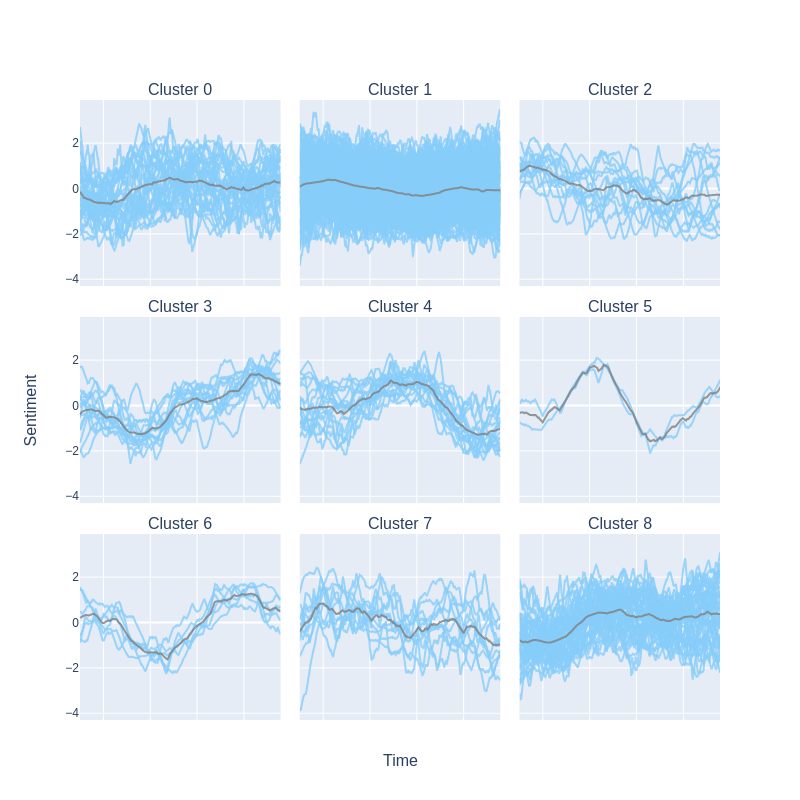

In [39]:
model = AgglomerativeClustering(linkage='complete', affinity='manhattan')
clusters_df['manhattan_sentiment'] = cluster(rolling_sentiment_df, model)

## On the differences between each timepoint

### Setup

In [40]:
diff_df = rolling_sentiment_df.diff(axis=1).dropna(axis=1)

### Euclidean

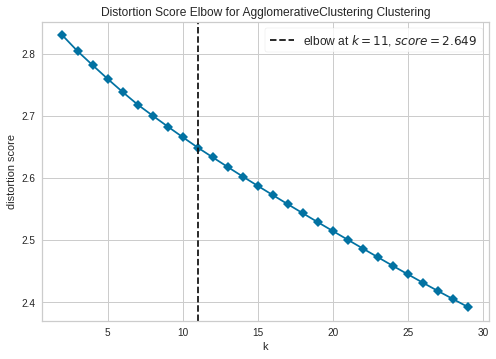

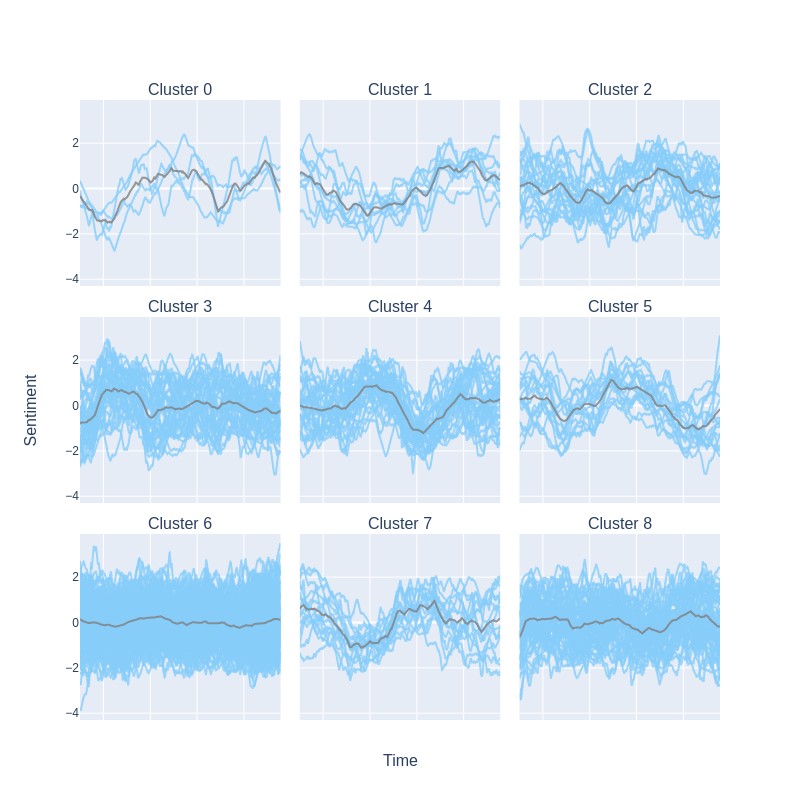

In [41]:
model = AgglomerativeClustering()
clusters_df['euclidean_diff'] = cluster(diff_df, model)

### Manhattan

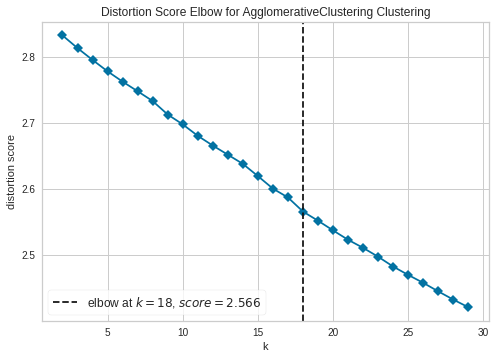

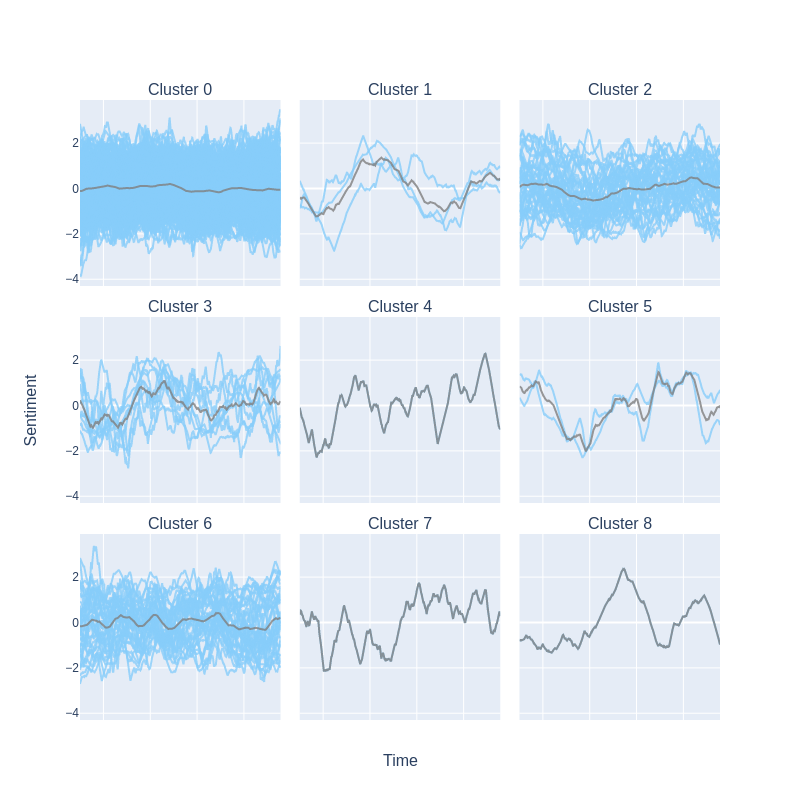

In [42]:
model = AgglomerativeClustering(linkage='complete', affinity='manhattan')
clusters_df['manhattan_diff'] = cluster(diff_df, model)

## On dynamic time warp distances

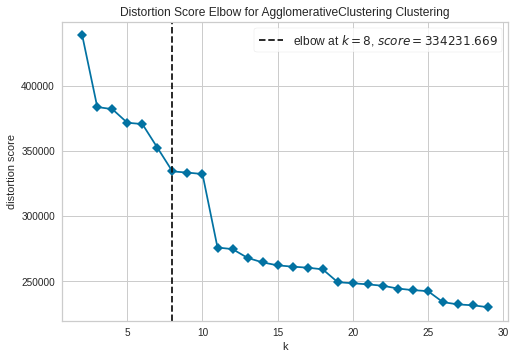

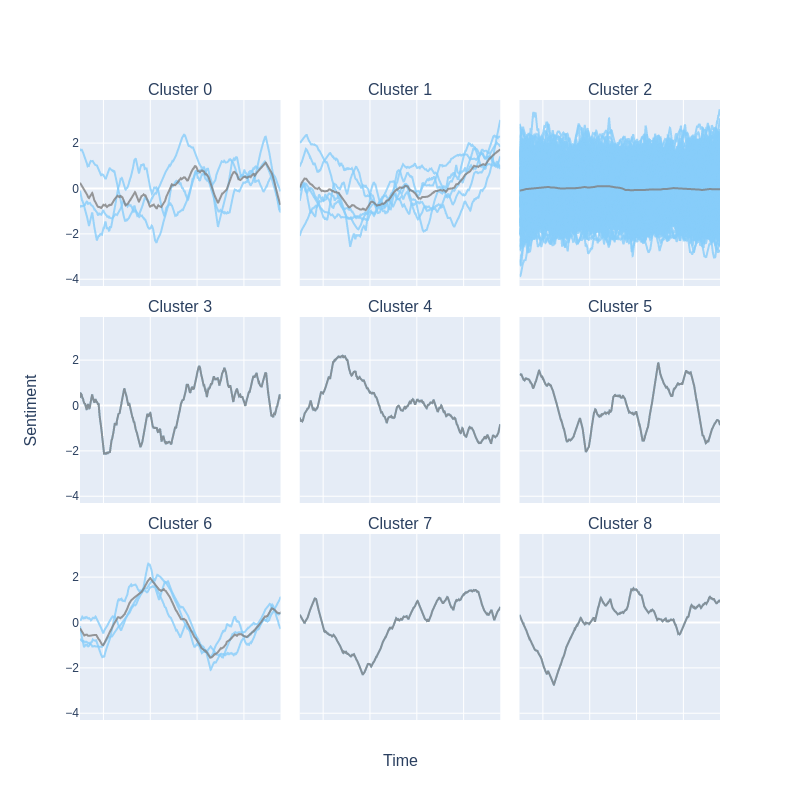

In [43]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete')
clusters_df['dtw_sentiment'] = cluster(dtw_df, model)

## Gold standard

We read in the gold standard clusterings and standardize their formatting

In [44]:
gold_standard_df = pd.read_json(os.path.join(base_path, 'tvtropes.clusters.json')).T.drop('id', axis=1)
gold_standard_df.sort_values('movie')
gold_standard_df.to_csv(os.path.join(base_path, 'gold_standard.csv'))

In [45]:
if not 'gold_standard_cluster' in clusters_df.columns:
    clusters_df['gold_standard_cluster'] = '0' 

In [46]:
for loc in clusters_df.index:
    if not pd.isna(clusters_df.loc[loc, 'gold_standard_cluster']) and clusters_df.loc[loc, 'gold_standard_cluster'] == '0':
        mapping = input(loc)
        clusters_df.loc[loc, 'gold_standard_cluster'] = mapping
        clusters_df.to_csv(os.path.join(base_path, 'clusters_shuffled.csv'))
    else:
        pass

There are 77 characters who appear in both datasets (have both inferred and gold standard clusterings):

In [47]:
clusters_df[~clusters_df['gold_standard_cluster'].isna()]

,euclidean_sentiment,manhattan_sentiment,euclidean_diff,manhattan_diff,dtw_sentiment,gold_standard_cluster
ALongKissGoodnight_TIMOTHY,4,0,6,0,2,casanova
Aliens_RIPLEY,1,1,6,0,2,final_girl
Aliens_BURKE,3,8,5,0,2,corrupt_corporate_executive
AllThePresidentsMen_BRADLEE,4,2,8,0,2,the_editor
Arthur_ARTHUR,6,8,4,0,2,ditz
...,...,...,...,...,...,...
tron_FLYNN,2,1,6,0,2,playful_hacker
tronlegacy_FLYNN,8,1,6,0,2,playful_hacker
uturn_JAKE,8,1,3,0,2,crazy_jealous_guy
wildwildwest_GORDON,0,0,7,2,2,gadgeteer_genius


#### Cluster Purities

According to Bamman et al. 2013 cluster purity metric

In [48]:
purity_df = clusters_df.copy().dropna()
value_counts = purity_df.value_counts('gold_standard_cluster')
supported_clusters = value_counts.where(value_counts > 1).dropna().index.to_list()
purity_df[purity_df['gold_standard_cluster'].isin(supported_clusters)].value_counts('gold_standard_cluster')

clusterings = purity_df.columns.to_list()
clusterings.remove('gold_standard_cluster')

purities = {}

for clustering in clusterings:
    purity = pd.crosstab(purity_df[clustering], purity_df['gold_standard_cluster']).max().sum() / len(purity_df)
    purities[clustering] = purity

In [49]:
purities

{'euclidean_sentiment': 0.6233766233766234,
 'manhattan_sentiment': 0.7922077922077922,
 'euclidean_diff': 0.7012987012987013,
 'manhattan_diff': 0.8051948051948052,
 'dtw_sentiment': 0.987012987012987}

#### Baseline cluster purities

Assigning each character randomly to a cluster based on the proportion of that cluster in the original clustering (According to Bamman et al. 2013 baseline methodology)

In [50]:
cluster_distributions_df = pd.DataFrame([clusters_df[clustering].value_counts().sort_index() / len(clusters_df) for clustering in clusterings])

In [51]:
np.random.seed(0)
purity_baseline_df = purity_df.copy()
for clustering in clusterings:
    purity_baseline_df[clustering] = np.random.choice(n_clusters, size=len(purity_baseline_df), p=cluster_distributions_df.loc[clustering])
    
baseline_purities = {}

for clustering in clusterings:
    purity = pd.crosstab(purity_baseline_df[clustering], purity_baseline_df['gold_standard_cluster']).max().sum() / len(purity_baseline_df)
    baseline_purities[clustering] = purity

In [52]:
baseline_purities

{'euclidean_sentiment': 0.6363636363636364,
 'manhattan_sentiment': 0.7012987012987013,
 'euclidean_diff': 0.6363636363636364,
 'manhattan_diff': 0.8831168831168831,
 'dtw_sentiment': 0.987012987012987}

In [53]:
scores = {}
for key in baseline_purities:
    scores[key] = purities[key] - baseline_purities[key]
scores

{'euclidean_sentiment': -0.012987012987012991,
 'manhattan_sentiment': 0.09090909090909094,
 'euclidean_diff': 0.06493506493506496,
 'manhattan_diff': -0.07792207792207784,
 'dtw_sentiment': 0.0}

In [54]:
average_score = np.mean(list(scores.values()))
average_score

0.012987012987013014

#### Visual inspection of gold-standard clusters

In [55]:
purity_df[purity_df['gold_standard_cluster'].isin(supported_clusters)].value_counts('gold_standard_cluster')

gold_standard_cluster
stoner                         5
crazy_jealous_guy              5
stupid_crooks                  4
loveable_rogue                 4
corrupt_corporate_executive    3
master_swordsman               3
adventurer_archaeologist       2
gadgeteer_genius               2
the_editor                     2
playful_hacker                 2
loser_protagonist              2
granola_person                 2
final_girl                     2
bounty_hunter                  2
father_to_his_men              2
evil_prince                    2
dumb_muscle                    2
drill_sargeant_nasty           2
consummate_professional        2
chanteuse                      2
byronic_hero                   2
warrior_poet                   2
dtype: int64

['haroldandkumar_HAROLD', 'haroldandkumar_KUMAR', 'pineappleexpress_DALE', 'pineappleexpress_SAUL', 'pineappleexpress_RED']


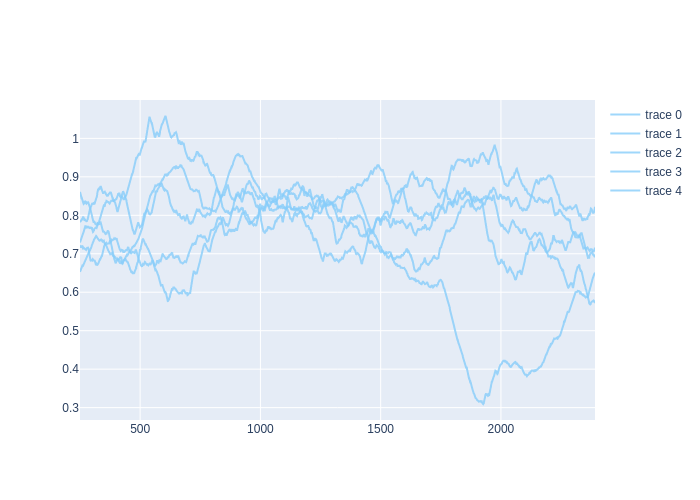

In [56]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'stoner'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['LAConfidential_BUD', 'piano_STEWART', 'rockyhorrorpictureshow_FRANK', 'scarface_TONY', 'uturn_JAKE']


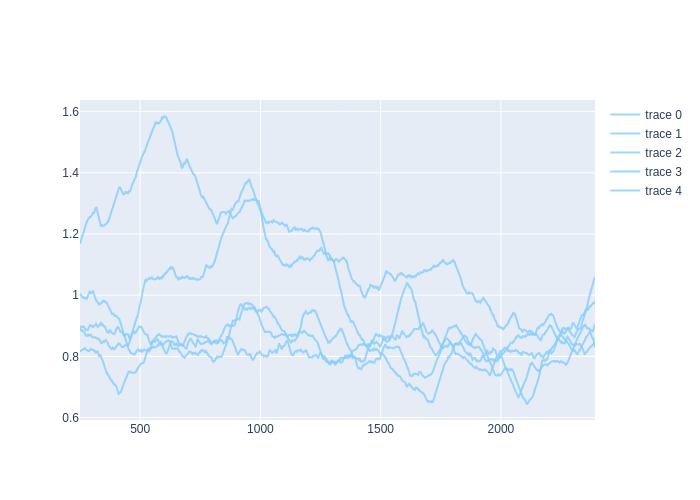

In [57]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'crazy_jealous_guy'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['Snatch_VINNY', 'Snatch_SOL', 'fargo_JERRY', 'pulpfiction_VINCENT']


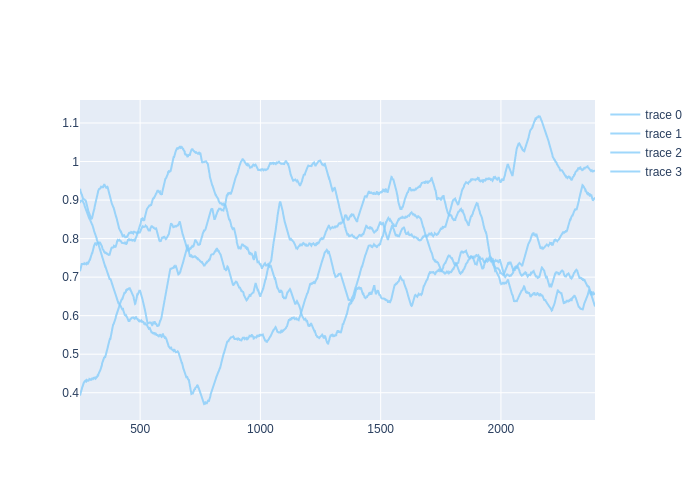

In [58]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'stupid_crooks'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['Inception_EAMES', "Pirates-of-the-Caribbean-Dead-Man's-Chest_JACKSPARROW", 'StarWarsANewHope_HAN', 'StarWarsTheEmpireStrikesBack_HAN']


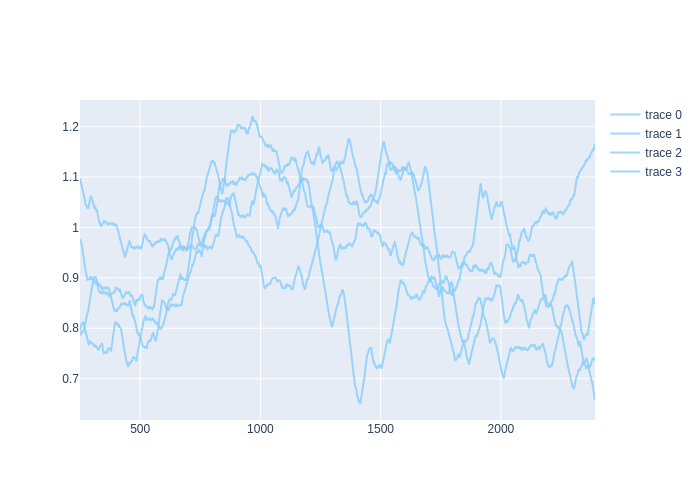

In [59]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'loveable_rogue'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()